# Setup


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
PROJECT_PATH = "/content/drive/My Drive/Deep_Learning_Assignments/Project/"
%cd "{PROJECT_PATH}"
!pip install livelossplot>/tmp/xxy
!pip install timm>/tmp/xxy
!pip install neptune-client>/tmp/xxy
!pip install ttach > /tmp/xxy
!pip install git+https://github.com/ildoonet/cutmix
# !git clone https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer
# %cd Ranger-Deep-Learning-Optimizer
# !pip install -e .
!pip install geffnet
%env NEPTUNE_API_TOKEN="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiM2UwMDkxZmItNDhlMi00MjEzLTkxMTAtYzBiOWQxNzk2MjUyIn0="
%env NEPTUNE_PROJECT_NAME=rohanrajpal/DLproject

/content/drive/My Drive/Deep_Learning_Assignments/Project
  Cloning https://github.com/ildoonet/cutmix to /tmp/pip-req-build-jqcaao1s
  Running command git clone -q https://github.com/ildoonet/cutmix /tmp/pip-req-build-jqcaao1s
  Created wheel for cutmix: filename=cutmix-0.1-cp36-none-any.whl size=3602 sha256=1cbbe8f6ef3e013c1798dbceeb14b275e219acc607d4b5cc3ed259eb75783775
  Stored in directory: /tmp/pip-ephem-wheel-cache-jyrq53op/wheels/8a/40/20/615302921d0fef73e55b17b5dd57169d4879dfe6dd7ad8ff50
Successfully built cutmix
env: NEPTUNE_API_TOKEN="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiM2UwMDkxZmItNDhlMi00MjEzLTkxMTAtYzBiOWQxNzk2MjUyIn0="
env: NEPTUNE_PROJECT_NAME=rohanrajpal/DLproject


# Imports


In [0]:
# %reload_ext plotcm
# https://github.com/rwightman/gen-efficientnet-pytorch
# from ranger import Ranger  # this is from ranger.py
# %cd ..
import torch
import torchvision
from torchvision.models import resnet18, densenet201, densenet121, densenet169
from torchvision.transforms import transforms as T
from torch.utils.data.sampler import SubsetRandomSampler

import pandas as pd
import torch.nn as nn
from tqdm.auto import tqdm as tq
import torch.optim as optim

from plotcm import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import geffnet

import random
import math
import os
from time import sleep

from livelossplot import PlotLosses
from livelossplot.outputs import NeptuneLogger

import numpy as np
import pandas as pd
import neptune
from timm import create_model
from sklearn.model_selection import StratifiedKFold, KFold
# from cutmix.cutmix import CutMix
from cutmix.utils import onehot, rand_bbox
from torch.utils.data.dataset import Dataset

from cutmix.utils import CutMixCrossEntropyLoss

if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')

neptune.init('rohanrajpal/DLproject')


Project(rohanrajpal/DLProject)

# Dataset

In [0]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0].split('/')[-1][:-4]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

class CutMix(torchvision.datasets.ImageFolder):
    def __init__(self, dataset, num_class, num_mix=1, beta=1., prob=1.0):
        self.dataset = dataset
        self.num_class = num_class
        self.num_mix = num_mix
        self.beta = beta
        self.prob = prob
        self.targets = dataset.targets
        self.imgs = dataset.imgs

    def __getitem__(self, index):
        img, lb = self.dataset[index]
        lb_onehot = onehot(self.num_class, lb)

        for _ in range(self.num_mix):
            r = np.random.rand(1)
            if self.beta <= 0 or r > self.prob:
                continue

            # generate mixed sample
            lam = np.random.beta(self.beta, self.beta)
            rand_index = random.choice(range(len(self)))

            img2, lb2 = self.dataset[rand_index]
            lb2_onehot = onehot(self.num_class, lb2)

            bbx1, bby1, bbx2, bby2 = rand_bbox(img.size(), lam)
            img[:, bbx1:bbx2, bby1:bby2] = img2[:, bbx1:bbx2, bby1:bby2]
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (img.size()[-1] * img.size()[-2]))
            lb_onehot = lb_onehot * lam + lb2_onehot * (1. - lam)

        return img, lb_onehot

    def __len__(self):
        return len(self.dataset)

In [0]:
class RandomErasing(object):
    '''
    Class that performs Random Erasing in Random Erasing Data Augmentation by Zhong et al. 
    -------------------------------------------------------------------------------------
    probability: The probability that the operation will be performed.
    sl: min erasing area
    sh: max erasing area
    r1: min aspect ratio
    mean: erasing value
    -------------------------------------------------------------------------------------
    '''
    def __init__(self, probability = 0.5, sl = 0.02, sh = 0.4, r1 = 0.3, mean=[0.4914, 0.4822, 0.4465]):
        self.probability = probability
        self.mean = mean
        self.sl = sl
        self.sh = sh
        self.r1 = r1
       
    def __call__(self, img):

        if random.uniform(0, 1) > self.probability:
            return img

        for attempt in range(100):
            area = img.size()[1] * img.size()[2]
       
            target_area = random.uniform(self.sl, self.sh) * area
            aspect_ratio = random.uniform(self.r1, 1/self.r1)

            h = int(round(math.sqrt(target_area * aspect_ratio)))
            w = int(round(math.sqrt(target_area / aspect_ratio)))

            if w < img.size()[2] and h < img.size()[1]:
                x1 = random.randint(0, img.size()[1] - h)
                y1 = random.randint(0, img.size()[2] - w)
                if img.size()[0] == 3:
                    img[0, x1:x1+h, y1:y1+w] = self.mean[0]
                    img[1, x1:x1+h, y1:y1+w] = self.mean[1]
                    img[2, x1:x1+h, y1:y1+w] = self.mean[2]
                else:
                    img[0, x1:x1+h, y1:y1+w] = self.mean[0]
                return img

        return img

In [0]:
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
        callback_get_label func: a callback-like function which takes two arguments - dataset and index
    """

    def __init__(self, dataset, indices=None, num_samples=None, callback_get_label=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices

        # define custom callback
        self.callback_get_label = callback_get_label

        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

        print(label_to_count)

    def _get_label(self, dataset, idx):
        if isinstance(dataset, torchvision.datasets.MNIST):
            return dataset.train_labels[idx].item()
        elif isinstance(dataset, torchvision.datasets.ImageFolder):
            return dataset.imgs[idx][1]
        elif self.callback_get_label:
            return self.callback_get_label(dataset, idx)
        else:
            raise NotImplementedError
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

# Train valid test split




In [0]:
img_size = 224
batch_size=32
num_workers=4

def get_train_valid_dataset(data_dir,
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True,
                           show_sample=False,
                           num_workers=4,
                           pin_memory=False,
                           split_no=1):
    """
    Utility function for loading and returning train and valid
    multi-process iterators over the CIFAR-10 dataset. A sample
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    valid_transform = T.Compose([
            T.Resize([img_size, img_size]),
            T.ToTensor(),
            normalize,
    ])
    if augment:
        train_transform = T.Compose([
          T.RandomApply([T.RandomAffine(45, shear=15)], 0.8),
          T.RandomResizedCrop(img_size, scale=(0.6, 1.0), ratio=(3/5, 5/3)),
          T.RandomHorizontalFlip(),
          T.RandomVerticalFlip(),
          T.ToTensor(),
          T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
          RandomErasing(probability=0.3, sh=0.3)])
    else:
        train_transform = T.Compose([
            T.Resize([img_size, img_size]),
            T.ToTensor(),
            normalize,
        ])
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_dir,
        transform=train_transform
    )
    # print(train_dataset.targets)
    # targets = 
    train_dataset = CutMix(train_dataset, num_class=3, beta=1.0, prob=0.5, num_mix=2) 
    # print(train_dataset.class_to_idx)
    valid_dataset = torchvision.datasets.ImageFolder(
        root=data_dir,
        transform=valid_transform
    )

    return (train_dataset, valid_dataset)


## Test loader

In [0]:
def get_test_loader(data_dir,
                    batch_size,
                    shuffle=True,
                    num_workers=4,
                    pin_memory=False):
    """
    Utility function for loading and returning a multi-process
    test iterator over the CIFAR-10 dataset.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - shuffle: whether to shuffle the dataset after every epoch.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - data_loader: test set iterator.
    """
    normalize = T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
    # define transform
    transform = T.Compose([
        T.Resize([img_size, img_size]),
        T.ToTensor(),
        normalize,
    ])

    dataset = ImageFolderWithPaths(
        root=data_dir,
        transform=transform
    )

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    return data_loader

# Test Dataloader

In [0]:
# train_loader, valid_loader = get_train_valid_loader(PROJECT_PATH + "data/train/",batch_size=32,augment=True,
#                                                     random_seed=42,valid_size=0.2,shuffle=True,show_sample=False,
#                                                     num_workers=4,pin_memory=True,split_no=2)
test_loader = get_test_loader(PROJECT_PATH + "data/test/",batch_size,False,4,True)

# Train

In [0]:
%time
# %load_ext autoreload
criterion = CutMixCrossEntropyLoss(True)

def eval(valid_loader, model, loss_compute, plot_matrix):
  model.eval()

  whole_loss = []
  whole_output = []
  whole_label = []

  with torch.no_grad():
    for batch_idx, (data,label) in enumerate(tq(valid_loader)):
      data, label = data.to(device, dtype=torch.float32), label.to(device)
      
      output = model(data)
      loss = loss_compute(output,label)
      whole_loss.append(loss.item())
      if plot_matrix:
        whole_output.append(output.cpu().detach().numpy())
        whole_label.append(label.cpu().detach().numpy())

  if plot_matrix:
    whole_label = np.concatenate(whole_label)
    whole_output = np.concatenate(whole_output)
    whole_output = whole_output.argmax(axis=1)

  if plot_matrix == True:
    plot_confusion_matrix(confusion_matrix(whole_label,whole_output),[str(x) for x in range(3)])

  return np.mean(whole_loss)

def train(epochs,data_loader,valid_loader,model,lr,best_wt_name):
  plotlosses = PlotLosses(groups={'log-loss': ['loss', 'val_loss']})
  optimizer = optim.AdamW(model.parameters(),lr=lr)
  # loss_compute = nn.CrossEntropyLoss()
  loss_compute = CutMixCrossEntropyLoss(True)
  lr_scheduler = None
  best_model = {'loss':100, 'path':PROJECT_PATH + "data/models/pytorchnb/" + best_wt_name}

  for i in tq(range(1,epochs+1)):
    model.train()

    whole_loss = []

    start_after = 1/4
    
    for param_group in optimizer.param_groups:
      print(param_group['lr'])

    if i == int(epochs*start_after) and lr_scheduler == None:
      print("Started scheduler")
      lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, int(epochs*(1-start_after)), eta_min = 1e-7)
    
    for batch_idx, (data,label) in enumerate(tq(data_loader)):
      optimizer.zero_grad()
      data, label = data.to(device, dtype=torch.float32), label.to(device)
      output = model(data)
      # print(output.shape)
      loss = loss_compute(output,label)
      loss.backward()

      whole_loss.append(loss.item())
      optimizer.step()
    
    train_loss = np.mean(whole_loss)

    valid_loss = eval(valid_loader,model,loss_compute,False)

    if best_model['loss'] > valid_loss:
      best_model['loss'] = valid_loss
      torch.save(model.state_dict(),best_model['path'])

    plotlosses.update({
        'loss': train_loss,
        'val_loss': valid_loss,
        # 'val_accuracy' : accuracy
    })
    plotlosses.send()
    neptune.log_metric('val_loss', valid_loss)
    neptune.log_metric('train_loss', train_loss)

    if lr_scheduler != None:
      lr_scheduler.step()

  # Confusion matrix of the best model
  model.load_state_dict(torch.load(best_model['path']))
  loss = eval(valid_loader,model,loss_compute,True)
  print("Best valid loss",loss)
  return model
  

def trainCNN(epochs,data_loader,valid_loader,model_name,pretrained,best_wt_name,lr,load_trained=False):
  # https://github.com/rwightman/pytorch-image-models
  # model = create_model(model_name, pretrained=True)
  if model_name == 'densenet201':
    model = densenet201(pretrained=True)
  elif model_name == 'densenet169':
    model = densenet169(pretrained=True)
  else:
    model = geffnet.create_model(model_name, pretrained=True,act_layer='mish')
  
  in_features = model.classifier.in_features
  model.classifier = nn.Linear(in_features=in_features, out_features=3, bias=True)
  model = model.to(device)
  # print(model)
  if load_trained:
    model.load_state_dict(torch.load(PROJECT_PATH+"data/models/pytorchnb/" + best_wt_name))
    return model
  # print(model)
  return train(epochs,data_loader,valid_loader,model,lr,best_wt_name)


# model_name = 'tf_efficientnet_b6'
# save_name = model_name+'_TTA_Oversampling_Adam_Pytorch'
# PARAMS = {'learning_rate' : 1e-4,
#           'n_epochs' : 20,
#           'optimizer' : 'Adam',
#           'model' : model_name
#           }
# neptune.create_experiment(name='pytorch-'+model_name+'-Adam', params=PARAMS)
# model = trainCNN(PARAMS['n_epochs'],train_loader,valid_loader,model_name,True,
#                  save_name,PARAMS['learning_rate'],False)

# model

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


# Predict

In [0]:
import torch.nn.functional as F
import ttach as tta

# tta_model = tta.ClassificationTTAWrapper(model, tta.aliases.flip_transform(), merge_mode='mean')

def predict(valid_loader, model, do_tta=False):
  if do_tta:
    model = tta.ClassificationTTAWrapper(model, tta.aliases.flip_transform(), merge_mode='mean')
  model.eval()

  # whole_loss = []
  whole_output = []
  whole_img_paths = []

  # loss_compute = nn.CrossEntropyLoss()

  with torch.no_grad():
    for batch_idx, (data,label, paths) in enumerate(tq(valid_loader)):
      data, label = data.to(device, dtype=torch.float32), label.to(device)
      output = model(data)
      whole_output.append(output.cpu().detach().numpy())
      whole_img_paths += paths

  whole_output = np.concatenate(whole_output)
  probs = F.softmax(torch.from_numpy(whole_output), dim=1)

  return whole_img_paths, probs

# preds_path,preds_prob = predict(test_loader, model, True)

# Make Submission

In [0]:
def make_submission(preds_prob,preds_path,save_name):
  test_path = PROJECT_PATH+"data/test/test"
  # test_path = PROJECT_PATH + "/other-data/test/"
  # print(model.data.classes)
  # submission = pd.DataFrame({'ID': [s.split('.')[0] for s in os.listdir(test_path)  if s.split('.')[1] != 'jfif']})
  submission = pd.DataFrame({'ID': preds_path})
  # submission
  for i, c in enumerate(['healthy_wheat', 'leaf_rust', 'stem_rust']):
    # print(preds_test[:,i].shape)
    # print(c)
    submission[c] = preds_prob[:,i]
  submission = submission[['ID', 'leaf_rust', 'stem_rust', 'healthy_wheat']] # Get same order as sample sub
  print(submission)
  submission.to_csv(PROJECT_PATH+'submissions/'+save_name+'.csv', index = False)

# Cross validation

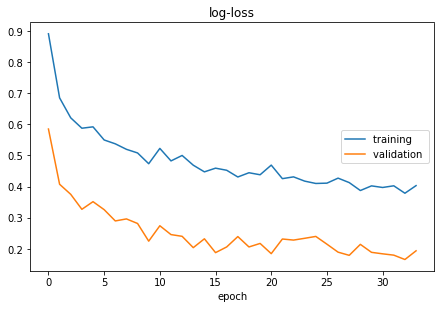

log-loss
	training         	 (min:    0.379, max:    0.891, cur:    0.403)
	validation       	 (min:    0.166, max:    0.585, cur:    0.194)
6.792031080967291e-06


In [0]:
num_splits = 5
all_probs = torch.zeros(610, 3, dtype=torch.float32)
# for i in range(2,2+1):
train_dataset, valid_dataset = get_train_valid_dataset(PROJECT_PATH + "data/train/",batch_size=batch_size,augment=True,
                                                    random_seed=42,valid_size=0.2,shuffle=True,show_sample=False,
                                                    num_workers=4,pin_memory=True,split_no=1)
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
# https://discuss.pytorch.org/t/how-can-i-use-sklearn-kfold-with-imagefolder/36577
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold

pin_memory=True
for fold_num, (train_index, test_index) in enumerate(tq(skf.split(train_dataset, train_dataset.targets))):
  # TODO: Fix Data leak
  # train_subset = torch.utils.data.Subset(train_dataset,train_index)
  # valid_subset = torch.utils.data.Subset(valid_dataset,test_index)
  
  if fold_num != 3:
    continue

  # train_sampler = ImbalancedDatasetSampler(train_dataset,train_index)
  # valid_sampler = ImbalancedDatasetSampler(valid_dataset,test_index)

  train_sampler = SubsetRandomSampler(train_index)
  valid_sampler = SubsetRandomSampler(test_index)

  train_loader = torch.utils.data.DataLoader(
      train_dataset, batch_size=batch_size, sampler=train_sampler,
      num_workers=num_workers, pin_memory=pin_memory
  )
  valid_loader = torch.utils.data.DataLoader(
      valid_dataset, batch_size=batch_size, sampler=valid_sampler,
      num_workers=num_workers, pin_memory=pin_memory
  )
  
  model_name = 'densenet169'
  optim_name = 'AdamW'
  lr = 1e-4
  PARAMS = {'learning_rate' : lr,
            'n_epochs' : 40,
            'optimizer' : optim_name,
            'model' : model_name,
            'fold' : fold_num,
            'save_name': model_name+'_TTA_'+optim_name+'_fold_'+str(fold_num)+"_img_"+str(img_size)+'_lr-'+str(lr)
            }
  neptune.create_experiment(name='pytorch-'+model_name+'-Adam', params=PARAMS)
  print("Started train for fold",fold_num)
  model = trainCNN(PARAMS['n_epochs'],train_loader,valid_loader,model_name,True,
                  PARAMS['save_name'],PARAMS['learning_rate'],False)
  preds_path,preds_prob = predict(test_loader, model,True)
  
  make_submission(preds_prob,preds_path,PARAMS['save_name'])

  all_probs+= preds_prob

# Change optimizer to adam maybe
# Or change the scheduler to cosine annealing

# TODO: Generate a CV score
# all_probs /= num_splits
# preds_path,preds_prob = preds_path, all_probs
# make_submission(preds_prob,preds_path,model_name+"_5-fold_cv_pytorch")